# ISIC 2024 Challenge - SKIN CANCER DETECTION

## Data Processing, Model Training, and Evaluation


### IMPORTS / LIBRARIES


In [72]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import xgboost as xgb
import lightgbm as lgb


from tensorflow.keras import layers, models
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier, RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
)

### NEURAL NETWORK MODEL


In [43]:
def ad_nn(input_shape):
    model = models.Sequential()
    model.add(layers.Dense(128, activation="relu", input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.4))

    model.add(layers.Dense(1, activation="sigmoid"))

    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

### LOADING METADATA


In [44]:
train_metadata_path = (
    "E:/W/ML NUST/(T5) CNN, RNN, LSTM/isic-2024-data/train-metadata.csv"
)
test_metadata_path = "E:/W/ML NUST/(T5) CNN, RNN, LSTM/isic-2024-data/test-metadata.csv"

train_metadata = pd.read_csv(train_metadata_path)
test_metadata = pd.read_csv(test_metadata_path)

print("Train Metadata Head:\n")
train_metadata.head()

C:\Users\jahme\AppData\Local\Temp\ipykernel_15768\2079513314.py:6: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  train_metadata = pd.read_csv(train_metadata_path)


Train Metadata Head:



,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [45]:
print("Test Metadata Head:\n")
test_metadata.head()

Test Metadata Head:



,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


#### Check for missing values


In [46]:
missing_values = train_metadata.isnull().sum()
print("Missing Values in Train Data:\n", missing_values)

Missing Values in Train Data:
 isic_id                              0
target                               0
patient_id                           0
age_approx                        2798
sex                              11517
anatom_site_general               5756
clin_size_long_diam_mm               0
image_type                           0
tbp_tile_type                        0
tbp_lv_A                             0
tbp_lv_Aext                          0
tbp_lv_B                             0
tbp_lv_Bext                          0
tbp_lv_C                             0
tbp_lv_Cext                          0
tbp_lv_H                             0
tbp_lv_Hext                          0
tbp_lv_L                             0
tbp_lv_Lext                          0
tbp_lv_areaMM2                       0
tbp_lv_area_perim_ratio              0
tbp_lv_color_std_mean                0
tbp_lv_deltaA                        0
tbp_lv_deltaB                        0
tbp_lv_deltaL                    

#### DATA CLEANING


In [47]:
columns_to_remove = [
    "lesion_id",
    "iddx_2",
    "iddx_3",
    "iddx_4",
    "iddx_5",
    "mel_mitotic_index",
    "mel_thick_mm",
]
train_metadata_cleaned = train_metadata.drop(columns=columns_to_remove, errors="ignore")
train_metadata_cleaned_no_nulls = train_metadata_cleaned.dropna()
train_metadata_cleaned_no_nulls["target"].value_counts()

target
0    381533
1       381
Name: count, dtype: int64

In [48]:
train_metadata_cleaned_no_nulls.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license,iddx_full,iddx_1,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,0.590476,85,-182.703552,613.493652,-42.427948,Memorial Sloan Kettering Cancer Center,CC-BY,Benign,Benign,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,0.285714,55,-0.078308,1575.687000,57.174500,Memorial Sloan Kettering Cancer Center,CC-BY,Benign,Benign,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,0.361905,105,123.649700,1472.010000,232.908900,Memorial Sloan Kettering Cancer Center,CC-BY,Benign,Benign,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,0.209581,130,-141.024780,1442.185791,58.359802,ACEMID MIA,CC-0,Benign,Benign,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,0.313433,20,-72.315640,1488.720000,21.428960,Memorial Sloan Kettering Cancer Center,CC-BY,Benign,Benign,70.442510


### EXPLORATORY DATA ANALYSIS (EDA)


#### 1. Age Approximation by Sex for Malignant Cases


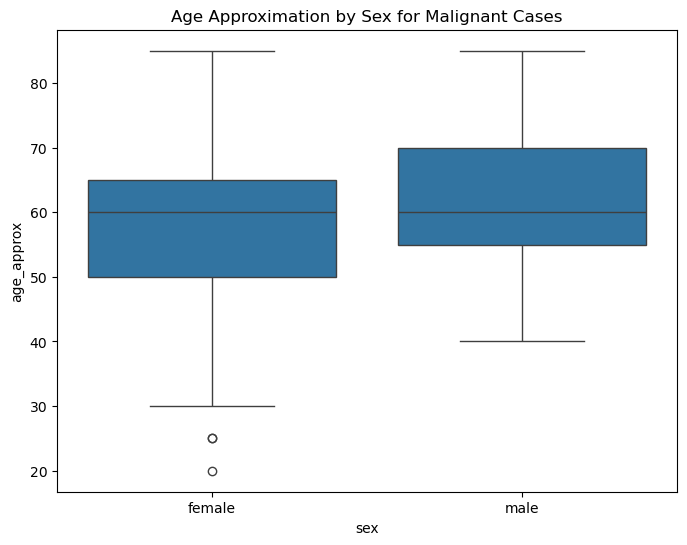

In [49]:
plt.figure(figsize=(8, 6))
sns.boxplot(
    x="sex",
    y="age_approx",
    data=train_metadata_cleaned_no_nulls[
        train_metadata_cleaned_no_nulls["target"] == 1
    ],
)
plt.title("Age Approximation by Sex for Malignant Cases")
plt.show()

#### 2. Distribution of Anatomical Site by Sex for Malignant Cases


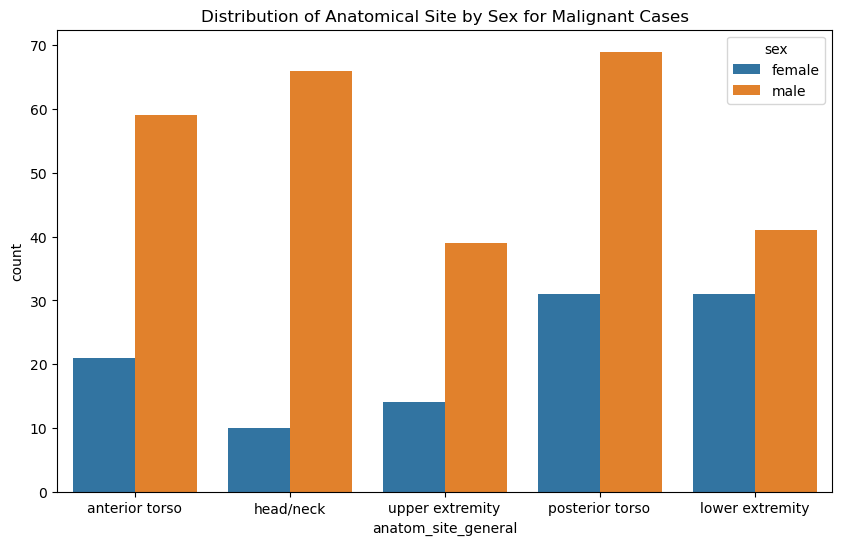

In [51]:
plt.figure(figsize=(10, 6))
sns.countplot(
    x="anatom_site_general",
    hue="sex",
    data=train_metadata_cleaned_no_nulls[
        train_metadata_cleaned_no_nulls["target"] == 1
    ],
)
plt.title("Distribution of Anatomical Site by Sex for Malignant Cases")
plt.show()

#### 3. Histogram of Clinical Size (Long Diameter mm) for Malignant Cases


In [52]:
# plt.figure(figsize=(10, 6))
# sns.histplot(
#     data=train_metadata_cleaned_no_nulls[
#         train_metadata_cleaned_no_nulls["target"] == 1
#     ],
#     x="mel_thick_mm",
#     bins=30,
#     kde=True,
# )
# plt.title("Histogram of Clinical Size (Long Diameter) for Malignant Cases")
# plt.show()

### DOWNSAMPLING


In [53]:
majority = train_metadata_cleaned_no_nulls[
    train_metadata_cleaned_no_nulls["target"] == 0
]
minority = train_metadata_cleaned_no_nulls[
    train_metadata_cleaned_no_nulls["target"] == 1
]
majority_class_downsample = resample(
    majority, replace=False, n_samples=len(minority), random_state=42
)
train_metadata_balanced = pd.concat([majority_class_downsample, minority])


print("Shpareee after balancing classes: ", train_metadata_balanced.shape)
print(
    "Class Dist. after balancing: \n", train_metadata_balanced["target"].value_counts()
)

Shpareee after balancing classes:  (762, 48)
Class Dist. after balancing: 
 target
0    381
1    381
Name: count, dtype: int64


### MAPPING DATA


In [54]:
train_metadata_balanced["sex"] = train_metadata_balanced["sex"].map(
    {"male": 1, "female": 0}
)

anatom_site_mapping = {
    "posterior torso": 1,
    "lower extremity": 2,
    "anterior torso": 3,
    "upper extremity": 4,
    "head/neck": 5,
}

tbp_lv_location_mapping = {
    "Torso Front Top Half": 1,
    "Torso Back Top Third": 2,
    "Head & Neck": 3,
    "Torso Back Middle Third": 4,
    "Left Leg - Lower": 5,
    "Right Leg - Lower": 6,
    "Torso Front Bottom Half": 7,
    "Left Arm - Upper": 8,
    "Left Leg - Upper": 9,
    "Right Arm - Upper": 10,
    "Right Leg - Upper": 11,
    "Left Arm - Lower": 12,
    "Right Arm - Lower": 13,
    "Torso Back Bottom Third": 14,
    "Left Leg": 15,
    "Right Leg": 16,
    "Left Arm": 17,
    "Right Arm": 18,
}


tbp_lv_location_simple_mapping = {
    "Torso Back": 1,
    "Torso Front": 2,
    "Left Leg": 3,
    "Head & Neck": 4,
    "Right Leg": 5,
    "Left Arm": 6,
    "Right Arm": 7,
}


train_metadata_balanced["anatom_site_general"] = train_metadata_balanced[
    "anatom_site_general"
].apply(lambda x: anatom_site_mapping.get(x, 0))

train_metadata_balanced["tbp_lv_location"] = train_metadata_balanced[
    "tbp_lv_location"
].apply(lambda x: tbp_lv_location_mapping.get(x, 0))

train_metadata_balanced["tbp_lv_location_simple"] = train_metadata_balanced[
    "tbp_lv_location_simple"
].apply(lambda x: tbp_lv_location_simple_mapping.get(x, 0))

In [56]:
train_metadata_balanced.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license,iddx_full,iddx_1,tbp_lv_dnn_lesion_confidence
44730,ISIC_1176500,0,IP_4013104,50.0,0,1,3.35,TBP tile: close-up,3D: white,21.195278,...,0.726667,60,-103.079308,1195.573975,227.486694,Memorial Sloan Kettering Cancer Center,CC-BY,Benign,Benign,99.990058
362429,ISIC_9047349,0,IP_9057861,80.0,1,2,2.82,TBP tile: close-up,3D: white,17.323980,...,0.460432,110,-170.181000,764.250000,29.220830,Memorial Sloan Kettering Cancer Center,CC-BY,Benign,Benign,99.999270
17389,ISIC_0500366,0,IP_6894380,45.0,0,1,4.81,TBP tile: close-up,3D: white,19.021500,...,0.207865,15,66.219480,1457.846000,78.279170,Memorial Sloan Kettering Cancer Center,CC-BY,Benign,Benign,99.999990
367815,ISIC_9176171,0,IP_6422845,70.0,1,1,4.19,TBP tile: close-up,3D: white,19.501620,...,0.334615,55,-39.389570,1057.866000,169.172800,Memorial Sloan Kettering Cancer Center,CC-BY,Benign,Benign,99.997030
192982,ISIC_4857877,0,IP_7331742,65.0,1,2,2.52,TBP tile: close-up,3D: XP,21.714430,...,0.185185,55,-150.631100,749.153000,-3.548462,"Department of Dermatology, Hospital Clínic de ...",CC-BY-NC,Benign,Benign,99.999950


### FEATURE ENGINEERING

##### ====== Can engineer more features in future.Handle the metadata accordingly =========


In [57]:
train_metadata_balanced["age_sex_interaction"] = (
    train_metadata_balanced["age_approx"] * train_metadata_balanced["sex"]
)

### PREPARING DATA FOR MODELS


In [58]:
X = train_metadata_balanced.drop(
    columns=[
        "isic_id",
        "target",
        "patient_id",
        "image_type",
        "tbp_tile_type",
        "attribution",
        "copyright_license",
        "iddx_full",
        "iddx_1",
        "tbp_lv_dnn_lesion_confidence",
    ]
)
y = train_metadata_balanced["target"]

In [59]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_val, y_train, y_val = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

In [60]:
train_dataset = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .batch(64)
    .shuffle(buffer_size=1024)
)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(64)


In [61]:
print(X_train.shape)
input_shape = (X_train.shape[1],)
print(input_shape)

(609, 39)
(39,)


#### TRAINING ON THE NEURAL NETWORK


In [63]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True
)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3
)
model = ad_nn(input_shape)
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.5368 - loss: 0.9759 - val_accuracy: 0.6078 - val_loss: 0.6671 - learning_rate: 0.0010
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5651 - loss: 0.8588 - val_accuracy: 0.7124 - val_loss: 0.6193 - learning_rate: 0.0010
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7002 - loss: 0.6572 - val_accuracy: 0.7190 - val_loss: 0.5886 - learning_rate: 0.0010
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7196 - loss: 0.5666 - val_accuracy: 0.7451 - val_loss: 0.5645 - learning_rate: 0.0010
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7149 - loss: 0.5909 - val_accuracy: 0.7516 - val_loss: 0.5479 - learning_rate: 0.0010
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7021 - loss: 0.5923 - val_accuracy: 0.7582 - val_loss: 0.5330 - learning_rate: 0.0010
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7423 - loss: 0.5147 - val_accuracy:

#### ACCURACY FOR NN ad_nn()


In [65]:
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Accuracy (NN): {val_accuracy:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8245 - loss: 0.4194
Validation Accuracy (NN): 0.8170


### STACKING MODELS


#### XGBoost


In [66]:
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    objective="binary:logistic",
    eval_metric="auc",
)
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

#### LGBoost

In [73]:
lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=7,
    num_leaves=31,
    min_child_samples=20,
    min_split_gain=0.01,
)
lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 302, number of negative: 307
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6600
[LightGBM] [Info] Number of data points in the train set: 609, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495895 -> initscore=-0.016421
[LightGBM] [Info] Start training from score -0.016421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

LGBMClassifier(learning_rate=0.05, max_depth=7, min_split_gain=0.01)

#### RandomForest

In [74]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=7,
    min_samples_split=10,
    random_state=42
)
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=7, min_samples_split=10, random_state=42)

#### Stacking XGB + LGB


In [75]:
base_learners = [("xgb", xgb_model), ("lgb", lgb_model), ("rf", rf_model)]
stacking_clf = StackingClassifier(
    estimators=base_learners, final_estimator=LogisticRegression()
)
stacking_clf.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 302, number of negative: 307
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6600
[LightGBM] [Info] Number of data points in the train set: 609, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.495895 -> initscore=-0.016421
[LightGBM] [Info] Start training from score -0.016421
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

StackingClassifier(estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='auc',
                                              feature_types=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interaction_constraints=None,
                                              learning...
                                              max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=100, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=None, ...)),
                               ('lgb',
                                LGBMClassifier(learning_rate=0.05, max_depth=7,
                                               min_split_gain=0.01)),
                               ('rf',
                                RandomForestClassifier(max_depth=7,
                                                       min_samples_split=10,
                                                       random_state=42))],
                   final_estimator=LogisticRegression())

### MODEL EVALUATION


In [76]:
# Neural network evaluation
val_loss, val_accuracy = model.evaluate(val_dataset)
print(f"Validation Accuracy (NN): {val_accuracy:.4f}")

# XGBoost evaluation
y_val_pred_xgb = xgb_model.predict_proba(X_val)[:, 1]
roc_auc_xgb = roc_auc_score(y_val, y_val_pred_xgb)
print(f"XGBoost ROC AUC Score: {roc_auc_xgb:.4f}")

# LightGBM evaluation
y_val_pred_lgb = lgb_model.predict_proba(X_val)[:, 1]
roc_auc_lgb = roc_auc_score(y_val, y_val_pred_lgb)
print(f"LightGBM ROC AUC Score: {roc_auc_lgb:.4f}")

# RandomForest evaluation
y_val_pred_rf = rf_model.predict_proba(X_val)[:, 1]
roc_auc_rf = roc_auc_score(y_val, y_val_pred_rf)
print(f"RandomForest ROC AUC Score: {roc_auc_rf:.4f}")


# Stacking model evaluation
y_val_pred_stacking = stacking_clf.predict_proba(X_val)[:, 1]
roc_auc_stacking = roc_auc_score(y_val, y_val_pred_stacking)
print(f"Stacking ROC AUC Score: {roc_auc_stacking:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8245 - loss: 0.4194
Validation Accuracy (NN): 0.8170
XGBoost ROC AUC Score: 0.9191
LightGBM ROC AUC Score: 0.9288
RandomForest ROC AUC Score: 0.9186
Stacking ROC AUC Score: 0.9237


### PREPARING THE TEST SET


In [ ]:
test_metadata_cleaned = test_metadata.drop(columns=columns_to_remove, errors="ignore")
test_metadata_cleaned["sex"] = test_metadata_cleaned["sex"].map(
    {"male": 1, "female": 0}
)
test_metadata_cleaned["anatom_site_general"] = test_metadata_cleaned[
    "anatom_site_general"
].apply(lambda x: anatom_site_mapping.get(x, 0))
test_metadata_cleaned["tbp_lv_location"] = test_metadata_cleaned[
    "tbp_lv_location"
].apply(lambda x: tbp_lv_location_mapping.get(x, 0))
test_metadata_cleaned["tbp_lv_location_simple"] = test_metadata_cleaned[
    "tbp_lv_location_simple"
].apply(lambda x: tbp_lv_location_simple_mapping.get(x, 0))

test_metadata_cleaned["age_sex_interaction"] = (
    test_metadata_cleaned["age_approx"] * test_metadata_cleaned["sex"]
)

In [ ]:
X_test = test_metadata_cleaned[X.columns]  # Align columns with training set
X_test_scaled = scaler.transform(X_test)

### FINAL PREDICTIONS

In [ ]:
test_predictions = stacking_clf.predict_proba(X_test_scaled)[:, 1]
test_predicted_labels = (test_predictions > 0.5).astype(int)

### SUBMISSIONS

In [ ]:
submission = pd.DataFrame(
    {"isic_id": test_metadata["isic_id"], "target": test_predicted_labels}
)
submission.to_csv(
    "C:/Users/jahme/Desktop/Prac/Kaggle/ISIC_Skin_Cancer/output/submission.csv",
    index=False,
)